muchpfpe_0min_Vpp: 7.40 V
muchpfpe_0min_Peak number: 119개
muchpfpe_0min_표준편차: 0.82
muchpfpe_0min_주파수: 6.07 Hz


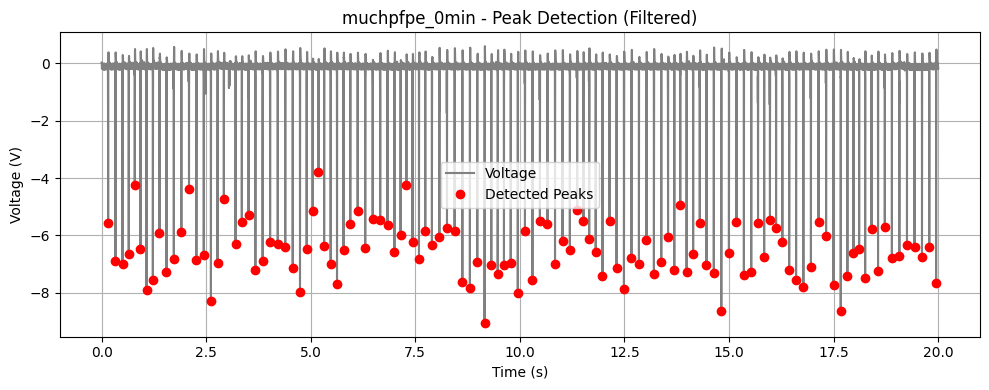

muchpfpe_10min_Vpp: 7.28 V
muchpfpe_10min_Peak number: 124개
muchpfpe_10min_표준편차: 0.76
muchpfpe_10min_주파수: 6.34 Hz


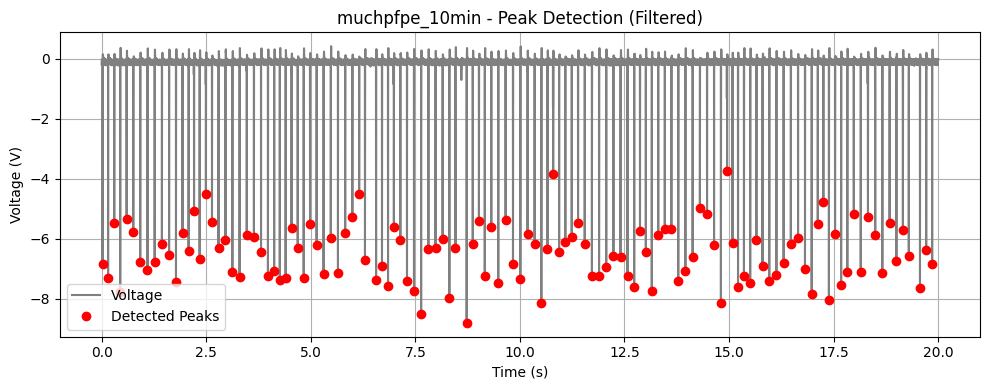

muchpfpe_11min_Vpp: 6.72 V
muchpfpe_11min_Peak number: 125개
muchpfpe_11min_표준편차: 0.63
muchpfpe_11min_주파수: 6.39 Hz


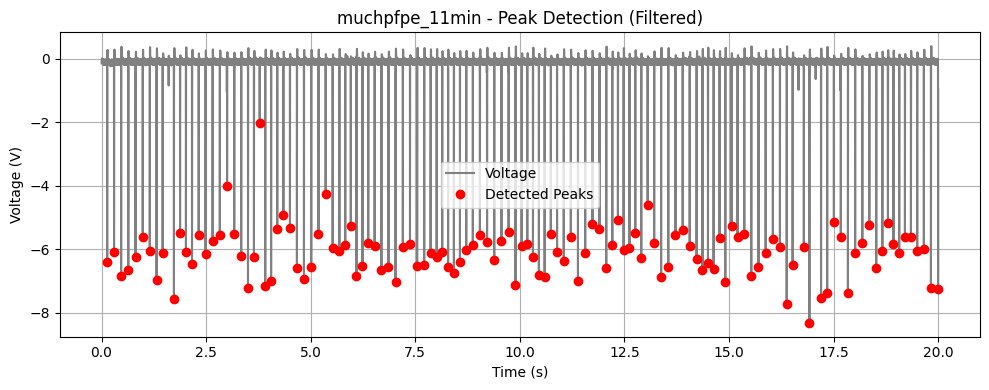

muchpfpe_12min_Vpp: 8.15 V
muchpfpe_12min_Peak number: 121개
muchpfpe_12min_표준편차: 1.00
muchpfpe_12min_주파수: 6.17 Hz


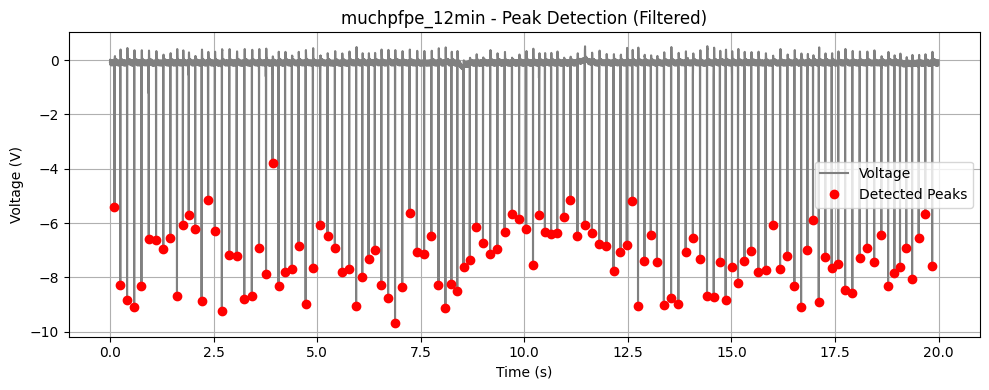

muchpfpe_13min_Vpp: 6.84 V
muchpfpe_13min_Peak number: 122개
muchpfpe_13min_표준편차: 0.67
muchpfpe_13min_주파수: 6.22 Hz


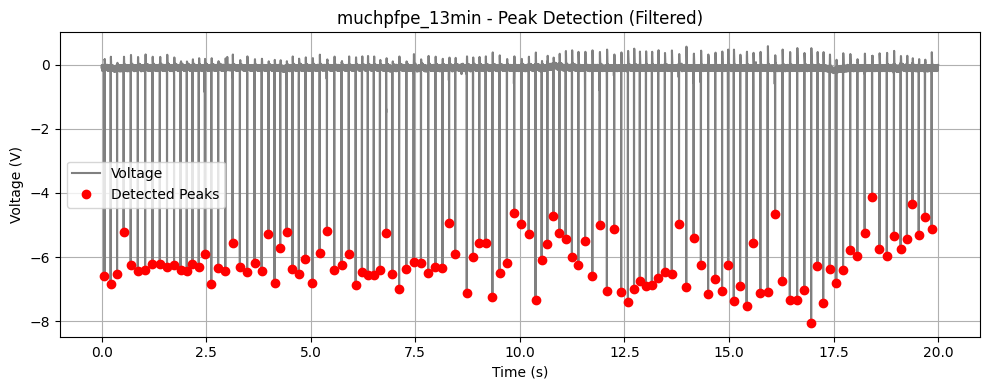

muchpfpe_14min_Vpp: 2.27 V
muchpfpe_14min_Peak number: 117개
muchpfpe_14min_표준편차: 0.40
muchpfpe_14min_주파수: 6.16 Hz


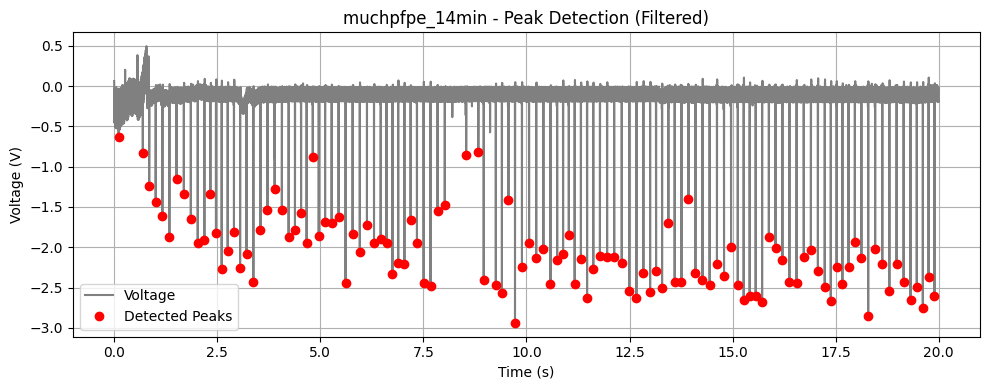

muchpfpe_15min_Vpp: 4.07 V
muchpfpe_15min_Peak number: 130개
muchpfpe_15min_표준편차: 0.42
muchpfpe_15min_주파수: 6.61 Hz


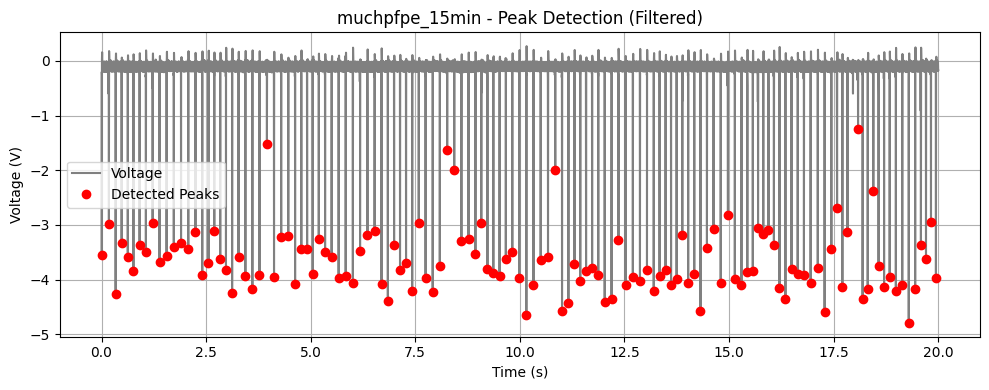

muchpfpe_16min_Vpp: 5.39 V
muchpfpe_16min_Peak number: 131개
muchpfpe_16min_표준편차: 0.45
muchpfpe_16min_주파수: 6.65 Hz


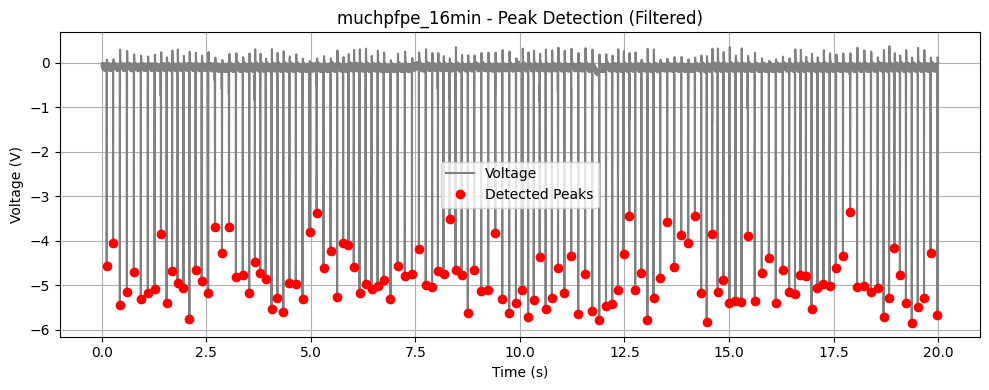

muchpfpe_17min_Vpp: 5.51 V
muchpfpe_17min_Peak number: 130개
muchpfpe_17min_표준편차: 0.47
muchpfpe_17min_주파수: 6.64 Hz


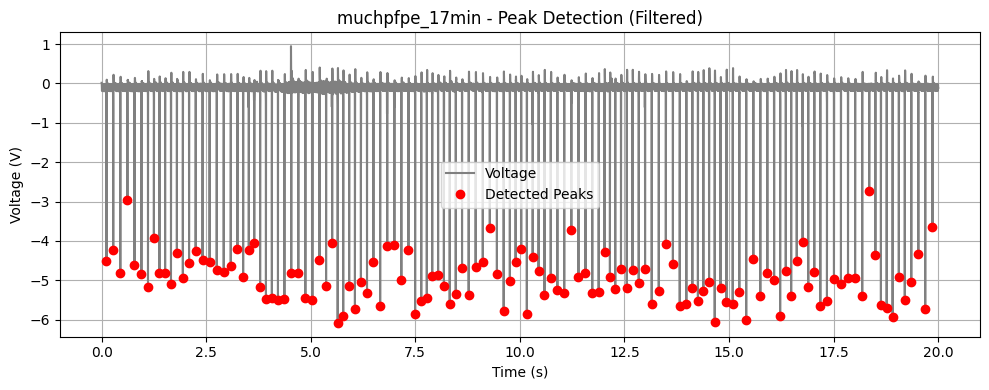

muchpfpe_18min_Vpp: 6.04 V
muchpfpe_18min_Peak number: 132개
muchpfpe_18min_표준편차: 0.51
muchpfpe_18min_주파수: 6.73 Hz


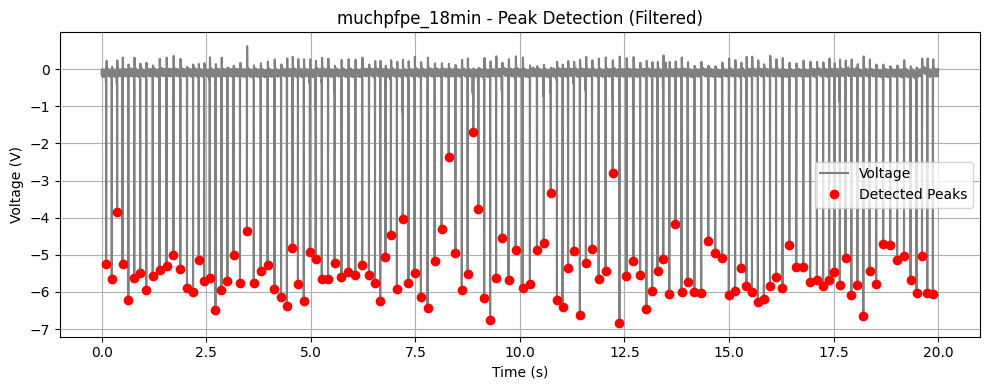

muchpfpe_19min_Vpp: 6.20 V
muchpfpe_19min_Peak number: 132개
muchpfpe_19min_표준편차: 0.54
muchpfpe_19min_주파수: 6.73 Hz


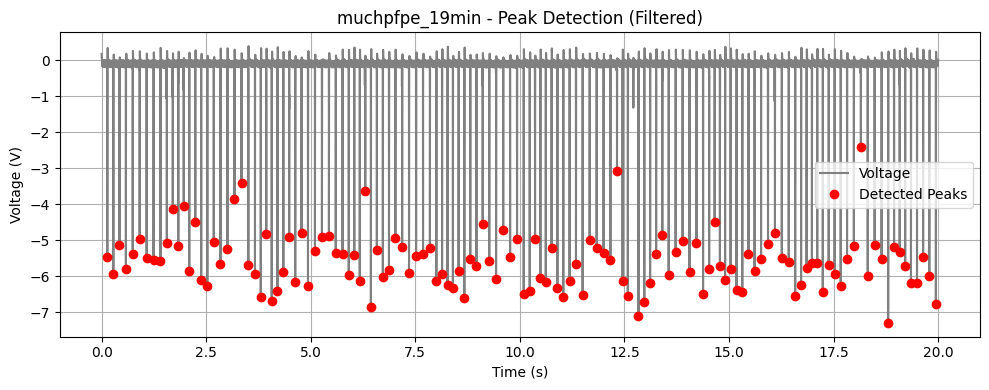

muchpfpe_1min_Vpp: 7.31 V
muchpfpe_1min_Peak number: 129개
muchpfpe_1min_표준편차: 1.19
muchpfpe_1min_주파수: 6.60 Hz


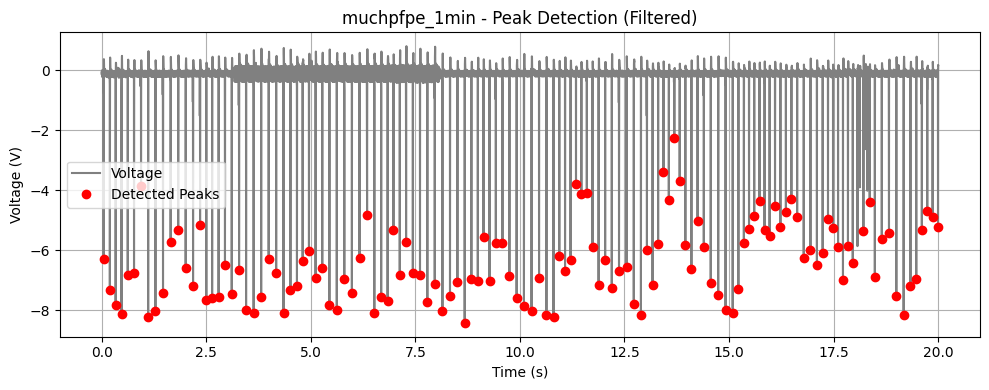

muchpfpe_2min_Vpp: 8.14 V
muchpfpe_2min_Peak number: 120개
muchpfpe_2min_표준편차: 0.71
muchpfpe_2min_주파수: 6.12 Hz


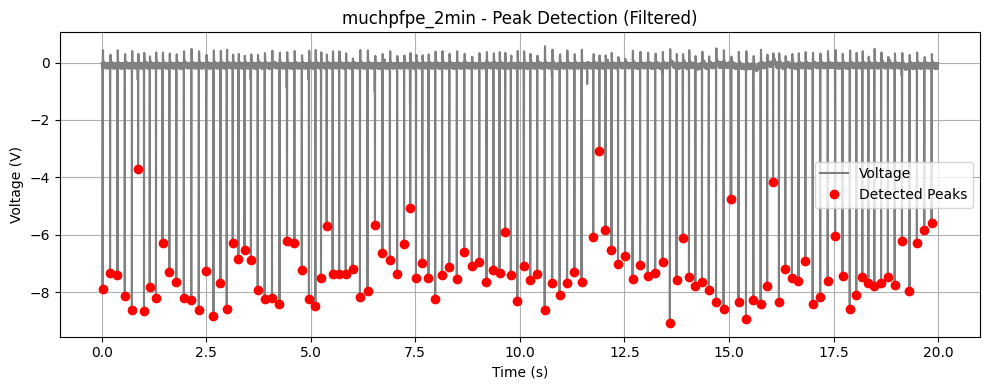

muchpfpe_3min_Vpp: 7.66 V
muchpfpe_3min_Peak number: 122개
muchpfpe_3min_표준편차: 0.59
muchpfpe_3min_주파수: 6.21 Hz


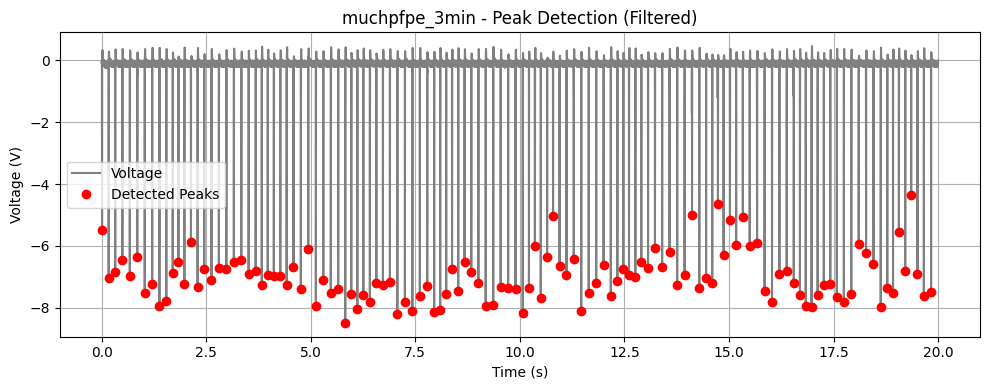

muchpfpe_4min_Vpp: 8.01 V
muchpfpe_4min_Peak number: 110개
muchpfpe_4min_표준편차: 0.54
muchpfpe_4min_주파수: 5.60 Hz


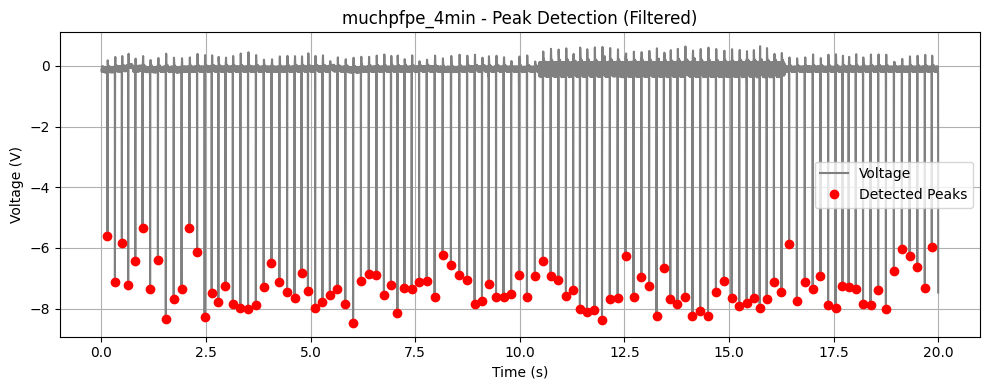

muchpfpe_5min_Vpp: 6.92 V
muchpfpe_5min_Peak number: 113개
muchpfpe_5min_표준편차: 0.57
muchpfpe_5min_주파수: 5.72 Hz


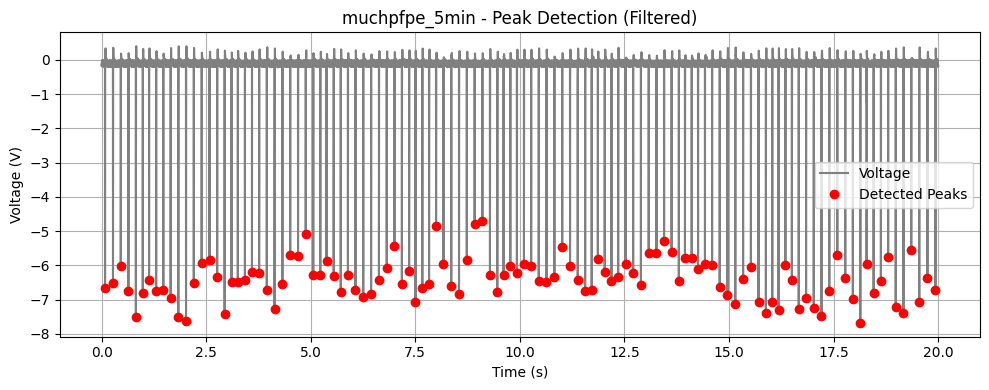

muchpfpe_6min_Vpp: 8.60 V
muchpfpe_6min_Peak number: 118개
muchpfpe_6min_표준편차: 0.54
muchpfpe_6min_주파수: 6.00 Hz


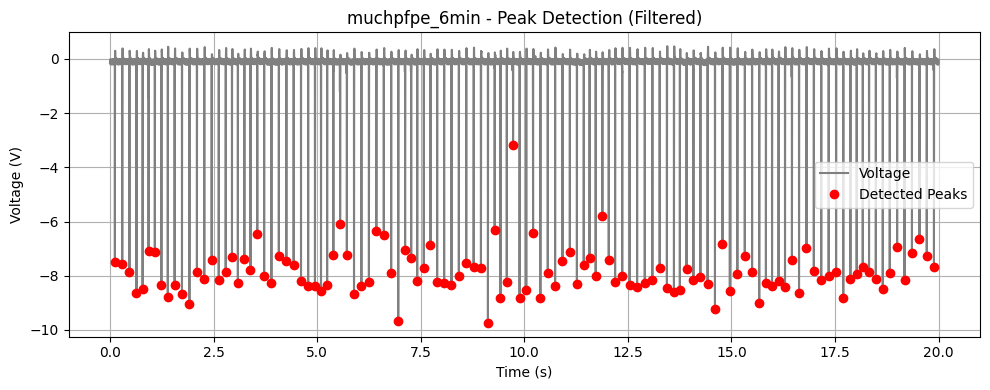

muchpfpe_7min_Vpp: 8.09 V
muchpfpe_7min_Peak number: 120개
muchpfpe_7min_표준편차: 0.50
muchpfpe_7min_주파수: 6.05 Hz


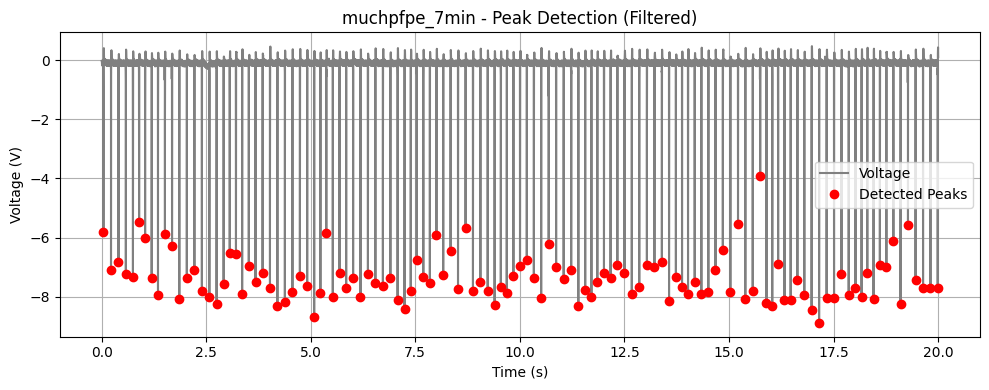

muchpfpe_8min_Vpp: 7.43 V
muchpfpe_8min_Peak number: 113개
muchpfpe_8min_표준편차: 0.68
muchpfpe_8min_주파수: 5.70 Hz


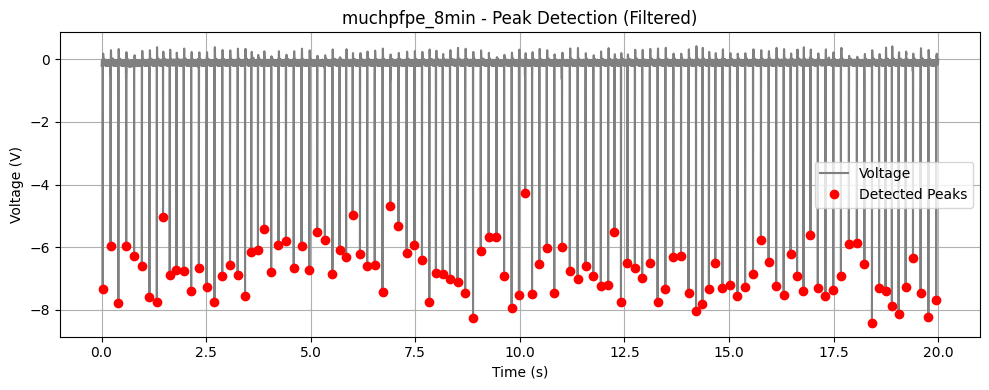

muchpfpe_9min_Vpp: 7.76 V
muchpfpe_9min_Peak number: 114개
muchpfpe_9min_표준편차: 0.79
muchpfpe_9min_주파수: 5.85 Hz


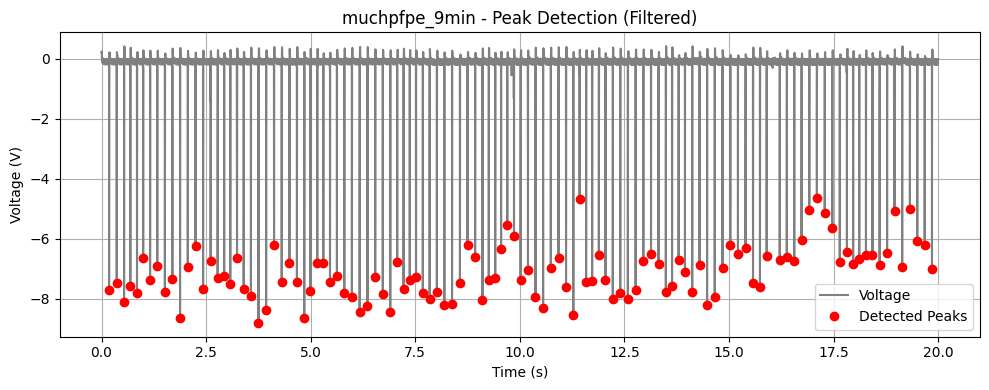


📊 모든 파일의 평균 Vpp 값 목록
muchpfpe_0min.csv: 7.40 V
muchpfpe_10min.csv: 7.28 V
muchpfpe_11min.csv: 6.72 V
muchpfpe_12min.csv: 8.15 V
muchpfpe_13min.csv: 6.84 V
muchpfpe_14min.csv: 2.27 V
muchpfpe_15min.csv: 4.07 V
muchpfpe_16min.csv: 5.39 V
muchpfpe_17min.csv: 5.51 V
muchpfpe_18min.csv: 6.04 V
muchpfpe_19min.csv: 6.20 V
muchpfpe_1min.csv: 7.31 V
muchpfpe_2min.csv: 8.14 V
muchpfpe_3min.csv: 7.66 V
muchpfpe_4min.csv: 8.01 V
muchpfpe_5min.csv: 6.92 V
muchpfpe_6min.csv: 8.60 V
muchpfpe_7min.csv: 8.09 V
muchpfpe_8min.csv: 7.43 V
muchpfpe_9min.csv: 7.76 V

📈 전체 평균 Vpp: 6.79 V
📉 표준편차 (에러바): 1.55 V


In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# -------------------------------
# 사용자 설정값
prominence_ratio = 0.3 # 신호의 표준편차(std)에 곱해 피크 prominence 기준을 설정 / 주변 값보다 얼마나 돌출된 정도여야 피크로 인식할지를 결정
min_prominence = 0.1 # prominence의 최솟값 제한 / std가 너무 작아서 prominence가 너무 낮게 계산되는 경우를 방지
min_distance_sec = 0.1 #인접한 피크 간 최소 시간 간격 (초 단위)
snr_threshold = 1 # Signal-to-Noise Ratio 기준값 / 값이 높을수록 강한 피크만 통과
min_relative_height = 0.2 # 전체 최대 진폭의 20% 이상 

# -------------------------------
# 폴더 경로
folder_path = r"C:\Users\GCU\OneDrive - gachon.ac.kr\HI Lab\0. Projects\0. On going\2. Aloe inspired DEG\0. 실험자료\3. Material selection\250805_PFPE 다떨어짐 ㅠ\minimized_csv파일\MuchPFPE_내구도"

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
all_vpp_values = []

# -------------------------------
# 파일별 처리
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    try:
        # 데이터 로드
        df = pd.read_csv(file_path)
        time = df.iloc[:, 0].values
        voltage = df.iloc[:, 1].values

        # 샘플링 속도
        total_time = time[-1] - time[0]
        sampling_rate = len(time) / total_time
        distance = int(sampling_rate * min_distance_sec)

        # 피크 검출 (음의 피크 대상으로)
        prom = max(np.std(voltage) * prominence_ratio, min_prominence)
        raw_peaks, properties = find_peaks(-voltage, prominence=prom, distance=distance)

        # 피크 필터링
        max_amplitude = np.max(-voltage)
        final_peaks = []
        for i in raw_peaks:
            left = max(0, i - int(0.05 * sampling_rate))
            right = min(len(voltage), i + int(0.05 * sampling_rate))
            local_noise = max(np.std(voltage[left:right]), 1e-6)
            signal = -voltage[i]
            if signal > max_amplitude * min_relative_height and signal / local_noise > snr_threshold:
                final_peaks.append(i)

        final_peaks = np.array(final_peaks, dtype=int)
        peak_times = time[final_peaks]

        # Vpp 계산
        vpp_list = []
        for i in range(len(final_peaks) - 1):
            start = final_peaks[i]
            end = final_peaks[i + 1]
            vpp = np.max(voltage[start:end + 1]) - np.min(voltage[start:end + 1])
            vpp_list.append(vpp)

        mean_vpp = np.mean(vpp_list) if vpp_list else 0
        std = np.std(vpp_list, ddof=1) if vpp_list else 0

        # 주파수 계산
        if len(peak_times) < 2:
            mean_freq = 0
        else:
            periods = np.diff(peak_times)
            mean_freq = np.mean(1 / periods)

        # 결과 출력
        base_name = os.path.splitext(file_name)[0]
        print(f"{base_name}_Vpp: {mean_vpp:.2f} V")
        print(f"{base_name}_Peak number: {len(vpp_list):.0f}개")
        print(f"{base_name}_표준편차: {std:.2f}")
        print(f"{base_name}_주파수: {mean_freq:.2f} Hz")

        all_vpp_values.append(mean_vpp)

        # -------------------------------
        # 그래프 출력
        plt.figure(figsize=(10, 4))
        plt.plot(time, voltage, color='gray', label='Voltage')
        if len(final_peaks) > 0:
            plt.plot(time[final_peaks], voltage[final_peaks], 'ro', label='Detected Peaks')
        plt.title(f"{base_name} - Peak Detection (Filtered)")
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"{file_name} 처리 중 오류 발생: {e}")

# -------------------------------
# 전체 요약 출력
print("\n==============================")
print("📊 모든 파일의 평균 Vpp 값 목록")
for i, vpp in enumerate(all_vpp_values):
    print(f"{csv_files[i]}: {vpp:.2f} V")

if all_vpp_values:
    overall_mean = np.mean(all_vpp_values)
    overall_std = np.std(all_vpp_values, ddof=1)
    print("\n==============================")
    print(f"📈 전체 평균 Vpp: {overall_mean:.2f} V")
    print(f"📉 표준편차 (에러바): {overall_std:.2f} V")
else:
    print("📭 Vpp 데이터를 계산할 수 없습니다.")
